<a href="https://colab.research.google.com/github/oceam/agri-image/blob/main/codes/VegAnn_tuturial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a tuturial code for the VggAnn (https://github.com/simonMadec/VegAnn) deep learning networks

> **VegAnn**   
> Vegetation Annotation of a large multi-crop RGB Dataset acquired under diverse conditions for image semantic segmentation

# Hidden Codes

All the codes used in this course are hidden here

In [1]:
!pip install torch
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install segmentation_models_pytorch

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-5gv39ull
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-5gv39ull
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit 97303b01688e733f9e595b7dbf4811fce93fa592
  Running command git submodule update --init --recursive -q
  Encountered 22 file(s) that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb
        .notebooks/course_UvA-DL/06-graph-neural-networks.ipynb
        .notebooks/course_UvA-DL/07-deep-energy-based-generative-models.ipynb
        .notebooks/course_UvA-DL/08-

In [2]:
!git clone https://github.com/simonMadec/VegAnn.git

Cloning into 'VegAnn'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 201 (delta 8), reused 0 (delta 0), pack-reused 176
Receiving objects: 100% (201/201), 738.74 KiB | 16.42 MiB/s, done.
Resolving deltas: 100% (103/103), done.


# Start using

import some basic dependency packages

In [3]:
import pytorch_lightning as pl
import torch
import segmentation_models_pytorch as smp
import numpy as np
import cv2
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import matplotlib.pyplot as plt
from typing import Dict, List

import VegAnn model from the cloned folder `VegAnn/vegann/utils`

In [4]:
import sys
sys.path.insert(0, 'VegAnn/vegann/utils')

from vegan_model import VegAnnModel

## Load Image and Model weights from google drive

In [5]:
!gdown https://drive.google.com/uc?id=1azagsinfW4btSGaTi0XJKsRnFR85Gtaw
ckt_path = "/content/VegAnn.ckpt"
!gdown https://drive.google.com/uc?id=1QUkhkLI3Qk9gZgjW0TIEh2LrC8IXntMD
imname = "test.png"

Downloading...
From: https://drive.google.com/uc?id=1azagsinfW4btSGaTi0XJKsRnFR85Gtaw
To: /content/VegAnn.ckpt
100% 294M/294M [00:07<00:00, 39.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QUkhkLI3Qk9gZgjW0TIEh2LrC8IXntMD
To: /content/test.png
100% 411k/411k [00:00<00:00, 18.3MB/s]


load the weight of VggAnn model

In [6]:
checkpoint = torch.load(ckt_path, map_location=torch.device('cpu'))
model = VegAnnModel("Unet","resnet34",in_channels = 3, out_classes=1 )
model.load_state_dict(checkpoint["state_dict"])
preprocess_fn = smp.encoders.get_preprocessing_fn("resnet34", pretrained= "imagenet")
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 241MB/s]


VegAnnModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

In [7]:
def colorTransform_VegGround(im,X_true,alpha_vert,alpha_g):
    alpha = alpha_vert
    color = [97,65,38]
    image=np.copy(im)
    for c in range(3):
        image[:, :, c] =np.where(X_true == 0,image[:, :, c] *(1 - alpha) + alpha * color[c] ,image[:, :, c])
    alpha = alpha_g
    color = [34,139,34]
    for c in range(3):
        image[:, :, c] =np.where(X_true == 1,image[:, :, c] *(1 - alpha) + alpha * color[c] ,image[:, :, c])
    return image

## Predict the results

In [8]:

image = cv2.imread(imname)
im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
image = preprocess_input(im)
image = image.astype('float32')

inputs = torch.tensor(image) # , dtype=float
inputs = inputs.permute(2,0,1)
inputs = inputs[None,:,:,:]
logits = model(inputs)
pr_mask = logits.sigmoid()

pred = (pr_mask > 0.5).numpy().astype(np.uint8)

pred

array([[[[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8)

## Visualize the results

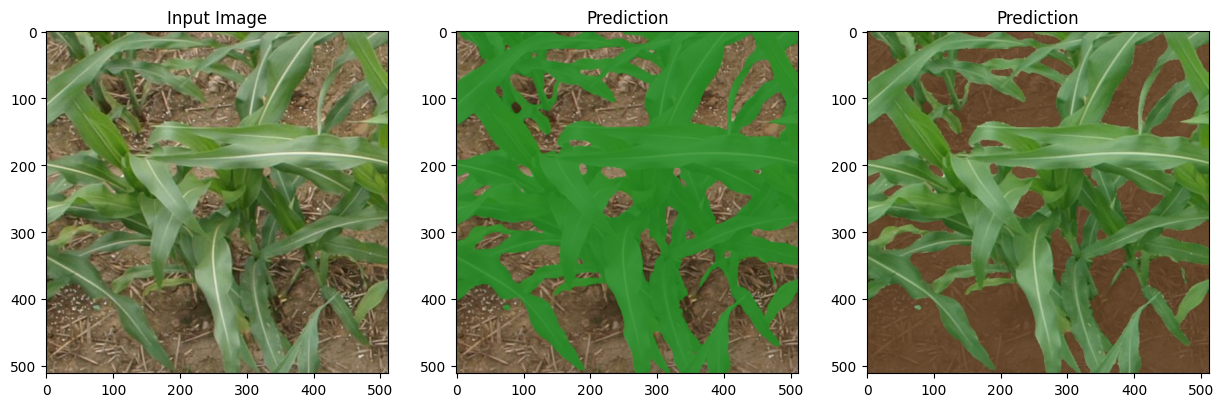

In [9]:
im1_pred = colorTransform_VegGround(im,pred,0.8,0.2)
im2_pred = colorTransform_VegGround(im,pred,0.2,0.8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 5))
ax1.imshow(im)
ax1.set_title("Input Image")

ax2.imshow(im2_pred)
ax2.set_title("Prediction")

ax3.imshow(im1_pred)
ax3.set_title("Prediction")

plt.show()